<a href="https://colab.research.google.com/github/Paymanshus/DL_Sem_VI/blob/main/Exp1/DL_Exp1_Flowers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Datasets for character/object recognition

Objectives:
1. Build ANN in keras for Arabic alphabets, Flower recognition (Daisy, tulip,  dandelion, rose,sunflower)
2. Plot accuracy vs validation accuracy
3. Plot loss vs validation loss
4. Calculate Precision, recall
5. Save model and load best model
6. Use callbacks 
7. Data augmentation if required


### Starter Code

### Flower Recognition Dataset

In [1]:
# !wget http://upscfever.com/datasets/flowers-new.zip -P drive/app
# import os
# os.chdir('drive/app')  #change dir
# !unzip -q flowers-new.zip  #unzip data in test/
# X=[]
# Z=[]
# IMG_SIZE=150
# FLOWER_DAISY_DIR='flowers/daisy'
# FLOWER_SUNFLOWER_DIR='flowers/sunflower'
# FLOWER_TULIP_DIR='flowers/tulip'
# FLOWER_DANDI_DIR='flowers/dandelion'
# FLOWER_ROSE_DIR='flowers/rose'
# le=LabelEncoder()
# Y=le.fit_transform(Z)
# Y=to_categorical(Y,5)
# X=np.array(X)
# X=X/255
# x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)

In [2]:
!wget http://upscfever.com/datasets/flowers-new.zip

--2020-12-07 02:32:58--  http://upscfever.com/datasets/flowers-new.zip
Resolving upscfever.com (upscfever.com)... 172.67.193.2, 104.27.176.133, 104.27.177.133, ...
Connecting to upscfever.com (upscfever.com)|172.67.193.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://upscfever.com/datasets/flowers-new.zip [following]
--2020-12-07 02:32:58--  https://upscfever.com/datasets/flowers-new.zip
Connecting to upscfever.com (upscfever.com)|172.67.193.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘flowers-new.zip.12’

flowers-new.zip.12      [          <=>       ]   5.74M  2.12MB/s    in 2.7s    

2020-12-07 02:33:02 (2.12 MB/s) - ‘flowers-new.zip.12’ saved [6021364]



In [3]:
!unzip flowers-new.zip

Archive:  flowers-new.zip
   creating: flowers/
   creating: flowers/daisy/
  inflating: flowers/daisy/100080576_f52e8ee070_n.jpg  
  inflating: flowers/daisy/11642632_1e7627a2cc.jpg  
  inflating: flowers/daisy/15207766_fc2f1d692c_n.jpg  
  inflating: flowers/daisy/21652746_cc379e0eea_m.jpg  
  inflating: flowers/daisy/25360380_1a881a5648.jpg  
  inflating: flowers/daisy/43474673_7bb4465a86.jpg  
  inflating: flowers/daisy/54377391_15648e8d18.jpg  
  inflating: flowers/daisy/5547758_eea9edfd54_n.jpg  
  inflating: flowers/daisy/5673551_01d1ea993e_n.jpg  
  inflating: flowers/daisy/5673728_71b8cb57eb.jpg  
  inflating: flowers/daisy/5794835_d15905c7c8_n.jpg  
  inflating: flowers/daisy/5794839_200acd910c_n.jpg  
  inflating: flowers/daisy/99306615_739eb94b9e_m.jpg  
   creating: flowers/dandelion/
  inflating: flowers/dandelion/10443973_aeb97513fc_m.jpg  
  inflating: flowers/dandelion/10683189_bd6e371b97.jpg  
  inflating: flowers/dandelion/10919961_0af657c4e8.jpg  
  inflating: flowe

## Importing required libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras

from sklearn.preprocessing import StandardScaler, LabelEncoder
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

from keras import layers
from keras import models
from keras import optimizers

from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
from keras.layers import Dropout, Flatten, Activation
from keras.preprocessing.image import ImageDataGenerator
from keras import Sequential

import cv2
from tqdm import tqdm
import os
import random as rn

In [5]:
np.random.seed(42)
rn.seed(42)
tf.random.set_seed(42)

In [6]:
# from google.colab import drive
# drive.mount('/content/drive')

## Data Preparation

### Creation of Training and Testing sets from image dataset

In [7]:
images = []
labels = []

In [8]:
IMG_SIZE=150
FLOWER_DAISY_DIR='flowers/daisy'
FLOWER_SUNFLOWER_DIR='flowers/sunflower'
FLOWER_TULIP_DIR='flowers/tulip'
FLOWER_DANDI_DIR='flowers/dandelion'
FLOWER_ROSE_DIR='flowers/rose'

In [9]:
flower_dirs = [FLOWER_DAISY_DIR, FLOWER_SUNFLOWER_DIR, FLOWER_TULIP_DIR, FLOWER_DANDI_DIR, FLOWER_ROSE_DIR]

In [10]:
flowers = ['Daisy', 'Sunflower', 'Tulip', 'Dandelion', 'Rose']

In [11]:
def generate_images(flower, DIR, num=10):
  for img in tqdm(os.listdir(DIR)):
    img = cv2.imread(DIR + '/' + img)
    img = img.reshape((1,) + img.shape)

    gen_datagen = ImageDataGenerator(
        rotation_range=10,  
          zoom_range = 0.1, 
          width_shift_range=0.2,
          height_shift_range=0.2,
          horizontal_flip=True,  
          rescale = 1/255
    )

    for idx, image_save in enumerate((gen_datagen.flow(img, 
                                                      batch_size=1, 
                                                      save_to_dir = DIR + '/', save_prefix=flower,
                                                      save_format='jpg'))):
      if idx == 30:
        break

In [12]:
# !rm -rf flowers

In [13]:
for flower, flower_dir in zip(flowers, flower_dirs):
  generate_images(flower, flower_dir)

100%|██████████| 26/26 [00:18<00:00,  1.42it/s]


In [14]:
len(os.listdir(FLOWER_DAISY_DIR))

407

In [15]:
def make_train_data(flower_type,DIR):
    for img in os.listdir(DIR):
        
        path = os.path.join(DIR,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        
        images.append(np.array(img))
        labels.append(str(flower_type))

In [16]:
for flower, flower_dir in zip(flowers, flower_dirs):
  make_train_data(flower, flower_dir)

In [17]:
for flower_dir in flower_dirs:
  print(str(len(os.listdir(flower_dir))) + flower_dir)

407flowers/daisy
801flowers/sunflower
798flowers/tulip
804flowers/dandelion
804flowers/rose


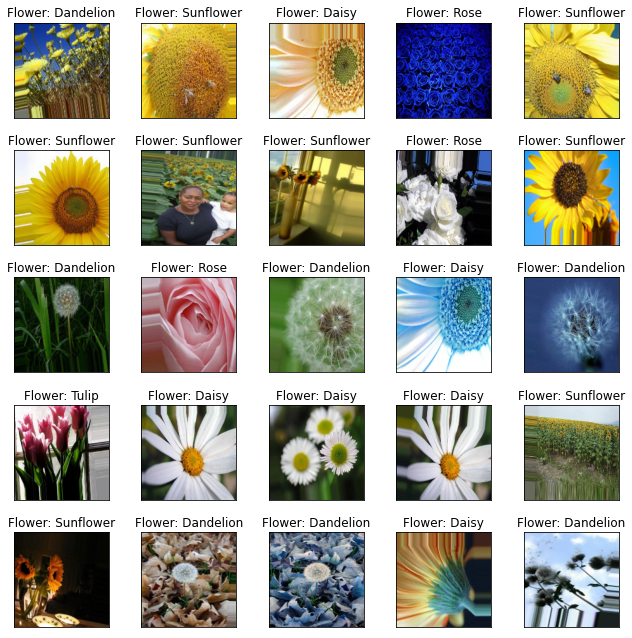

In [18]:
fig, ax = plt.subplots(5,5)
fig.set_size_inches(9,9)

for i in range(5):
  for j in range(5):

    ax[i][j].set_xticks([])
    ax[i][j].set_yticks([])

    l = rn.randint(0,len(labels))
    ax[i][j].imshow(images[l])
    ax[i][j].title.set_text('Flower: '+ labels[l])
    
plt.tight_layout()

In [19]:
le = LabelEncoder()
target = le.fit_transform(labels)
target = to_categorical(target, num_classes = 5)

In [20]:
images = np.array(images)
images = images/255

In [22]:
from sklearn.utils import shuffle

images, target = shuffle(images, target)

In [23]:
x_train, x_test, y_train, y_test = train_test_split(images, target, test_size=0.25, random_state=42)

In [24]:
IMG_HEIGHT = 150
IMG_WIDTH = 150
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)

BATCH_SIZE = 100

TRAIN_SIZE = images.shape[0]*0.8
VAL_SIZE = images.shape[0]*0.2

In [25]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images horizontally
        rescale = 1/255,
        validation_split=0.2
        )

# datagen.fit(x_train)

In [26]:
train_generator = datagen.flow_from_directory(
    'flowers/',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    target_size=(256,256),
    shuffle=True
    )

val_generator = datagen.flow_from_directory(
    'flowers/',
    batch_size = BATCH_SIZE,
    subset='validation',
    target_size=(256,256),
    shuffle=True
)

Found 2894 images belonging to 5 classes.
Found 720 images belonging to 5 classes.


### Model Preparation

In [27]:
# Callbacks

es = EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=6)
mc = ModelCheckpoint('best_weights.h5', monitor='val_loss', save_best_only=True, mode='max')
rd = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, mode='auto')

In [28]:
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense

In [129]:
# Modelling the CNN

model = Sequential()
model.add(Conv2D(filters=32, kernel_size=(5,5), padding='Same', activation='relu', input_shape=(150,150,3)))
model.add(MaxPool2D(pool_size=(2,2)))
# model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3,3), padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
# model.add(Dropout(0.25))

model.add(Conv2D(filters=96, kernel_size=(3,3),padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
# model.add(Dropout(0.15))
model.add(layers.BatchNormalization())

model.add(Conv2D(filters=128, kernel_size=(3,3),padding='Same', activation='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
# model.add(Dropout(0.5))


model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.30))

model.add(Dense(5, activation='softmax'))

In [130]:
optimizer = optimizers.RMSProp()

In [131]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [132]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_52 (Conv2D)           (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d_52 (MaxPooling (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 37, 37, 96)        55392     
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 18, 18, 96)        0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 18, 18, 96)      

In [133]:
# hist = model.fit(train_generator, epochs = 30, verbose=1,
#                  steps_per_epoch=train_generator.samples // BATCH_SIZE, 
#                  validation_data=val_generator,
#                  validation_steps=val_generator.samples // BATCH_SIZE,
#                  callbacks=[es,mc,rd]
#                  )

In [134]:
hist = model.fit(x_train, y_train, epochs=100, callbacks=[es, mc, rd], validation_split=0.2)

Epoch 1/100
68/68 [==============================] - 2s 33ms/step - loss: 1.3262 - accuracy: 0.4972 - val_loss: 1.6031 - val_accuracy: 0.2288
Epoch 2/100
68/68 [==============================] - 2s 29ms/step - loss: 0.7358 - accuracy: 0.7099 - val_loss: 1.5574 - val_accuracy: 0.2768
Epoch 3/100
68/68 [==============================] - 2s 29ms/step - loss: 0.4321 - accuracy: 0.8372 - val_loss: 1.4026 - val_accuracy: 0.3653
Epoch 4/100
68/68 [==============================] - 2s 29ms/step - loss: 0.3279 - accuracy: 0.8879 - val_loss: 1.2690 - val_accuracy: 0.4908
Epoch 5/100
68/68 [==============================] - 2s 29ms/step - loss: 0.1608 - accuracy: 0.9451 - val_loss: 0.8813 - val_accuracy: 0.6697
Epoch 6/100
68/68 [==============================] - 2s 29ms/step - loss: 0.1679 - accuracy: 0.9437 - val_loss: 0.5866 - val_accuracy: 0.8100
Epoch 7/100
68/68 [==============================] - 2s 29ms/step - loss: 0.0866 - accuracy: 0.9686 - val_loss: 0.2514 - val_accuracy: 0.9336
Epoch 

In [135]:
pred = model.evaluate(x_test, y_test)

29/29 [==============================] - 0s 10ms/step - loss: 0.0996 - accuracy: 0.9812


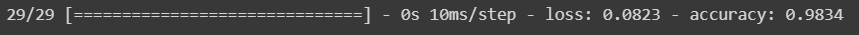

## Evaluating Model Performance

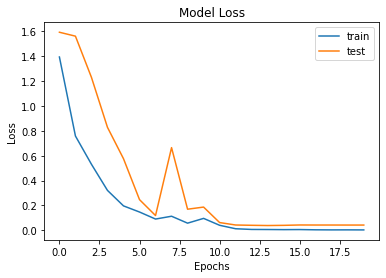

In [118]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

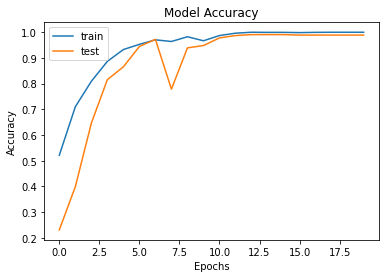

In [119]:
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()
